# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [161]:
import pygpu
import pickle
import os
import pandas as pd

In [10]:
import lasagne

In [11]:
!mkdir cifar10
!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

mkdir: cannot create directory ‘cifar10’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0   798k      0  0:03:28  0:03:28 --:--:--  950k
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [164]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [165]:
X_train /= np.std(X_train, axis = 0)
X_test /= np.std(X_test, axis = 0)

In [166]:
X_test_splited, X_val, y_test_splited, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=0)

In [167]:
X_test = np.float32(X_test)
X_test_splited = np.float32(X_test_splited)
X_train = np.float32(X_train)
X_val = np.float32(X_val)

In [168]:
y_test = np.int32(y_test)
y_test_splited = np.int32(y_test_splited)
y_train = np.int32(y_train)
y_val = np.int32(y_val)

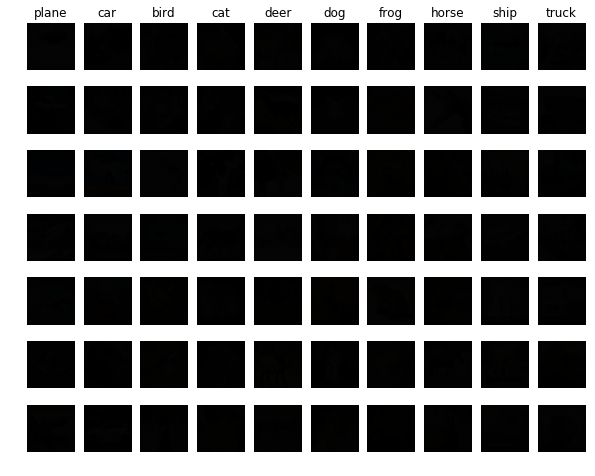

In [169]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

<Ответ>

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

<Ответ>


**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ>

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

<Ответ>

In [170]:
import lasagne
from lasagne import init
from lasagne.layers import InputLayer, DropoutLayer, FlattenLayer, batch_norm
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.utils import floatX
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X", 'float32')
target_y = T.vector("target Y integer", 'int32')

In [171]:
net = {}
net['input'] = InputLayer((None, 3, 32, 32), input_var=input_X)

net['conv1'] = batch_norm(ConvLayer(net['input'], num_filters=192, filter_size=5, pad=2, flip_filters=False, W=init.HeNormal(gain='relu')))
net['cccp1'] = batch_norm(ConvLayer(net['conv1'], num_filters=160, filter_size=1, flip_filters=False, W=init.HeNormal(gain='relu')))
net['cccp2'] = batch_norm(ConvLayer(net['cccp1'], num_filters=96, filter_size=1, flip_filters=False, W=init.HeNormal(gain='relu')))
net['pool1'] = PoolLayer(net['cccp2'], pool_size=3, stride=2, mode='max', ignore_border=False)
net['drop3'] = DropoutLayer(net['pool1'], p=0.6)

net['conv2'] = batch_norm(ConvLayer(net['drop3'], num_filters=192, filter_size=5, pad=2, flip_filters=False, W=init.HeNormal(gain='relu')))
net['cccp3'] = batch_norm(ConvLayer(net['conv2'], num_filters=192, filter_size=1, flip_filters=False, W=init.HeNormal(gain='relu')))
net['cccp4'] = batch_norm(ConvLayer(net['cccp3'], num_filters=192, filter_size=1, flip_filters=False, W=init.HeNormal(gain='relu')))
net['pool2'] = PoolLayer(net['cccp4'], pool_size=3, stride=2, mode='average_exc_pad', ignore_border=False)
net['drop6'] = DropoutLayer(net['pool2'], p=0.6)

net['conv3'] = batch_norm(ConvLayer(net['drop6'], num_filters=192, filter_size=3, pad=1, flip_filters=False, W=init.HeNormal(gain='relu')))
net['cccp5'] = batch_norm(ConvLayer(net['conv3'], num_filters=192, filter_size=1, flip_filters=False, W=init.HeNormal(gain='relu')))
net['cccp6'] = batch_norm(ConvLayer(net['cccp5'], num_filters=10, filter_size=1, flip_filters=False, W=init.HeNormal(gain='relu')))
net['pool3'] = PoolLayer(net['cccp6'], pool_size=8, mode='average_exc_pad', ignore_border=False)

net['output'] = lasagne.layers.DenseLayer(net['pool3'], num_units = 10, nonlinearity=softmax)
#net['output'] = lasagne.layers.FlattenLayer(net['pool3'])#, outdim=10)

In [172]:
y_predicted = lasagne.layers.get_output(net['output'])
all_weights = lasagne.layers.get_all_params(net['output'], trainable=True)
print(all_weights)

[W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, b]


In [173]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

In [178]:
updates = lasagne.updates.adam(loss, all_weights, learning_rate=.0002)
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates)
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить

In [179]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [184]:
def init_frame():
    frame = pd.DataFrame()
    frame['epoch'] = 0
    frame['loss'] = 0
    frame['train_acc'] = 0
    frame['val_acc'] = 0
    return frame

In [199]:
def print_acc(accs, name_png=None):
    plt.figure(figsize=(12, 8))
    plt.plot(accs['epoch'], accs['train_acc'], label='train_acc')
    plt.plot(accs['epoch'], accs['val_acc'], label='val_acc')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title('Accs')
    if name_png is not None:
        plt.savefig('models/' + name_png)
    
def print_loss(accs):
    plt.figure(figsize=(12, 8))
    plt.plot(accs['epoch'], accs['loss'], label='loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Loss')

In [185]:
acc_frame = init_frame()

In [186]:
acc_frame

,epoch,loss,train_acc,val_acc


In [187]:
## import time

num_epochs = 200 #количество проходов по данным

batch_size = 128 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(np.float32(X_train), y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    acc_line = {'epoch' : epoch + 1, 'loss' : train_err / train_batches, 
                'train_acc' : train_acc / train_batches * 100, 
                'val_acc' : val_acc / val_batches * 100}
    acc_frame.loc[len(acc_frame.index)] = acc_line
    print("Epoch {} took {:.3f}s".format(acc_line['epoch'], time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(acc_line['loss']))
    print("  train accuracy:\t\t{:.2f} %".format(acc_line['train_acc']))
    print("  validation accuracy:\t\t{:.2f} %".format(acc_line['val_acc']))
    
    if (epoch+1) % 10 == 0:
        #save the network and its parameters as a dictionary
        netInfo = {'network': net['output'], 'params': lasagne.layers.get_all_param_values(net['output'])}
        Net_FileName = 'model' + str(epoch+1) + '.pkl'
        # save the dictionary as a .pkl file
        pickle.dump(netInfo, open(os.path.join('models/', Net_FileName), 'wb'),protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1 took 197.583s
  training loss (in-iteration):		0.928899
  train accuracy:		69.33 %
  validation accuracy:		67.71 %
Epoch 2 took 197.597s
  training loss (in-iteration):		0.876982
  train accuracy:		70.93 %
  validation accuracy:		69.58 %
Epoch 3 took 197.589s
  training loss (in-iteration):		0.827297
  train accuracy:		72.45 %
  validation accuracy:		70.42 %
Epoch 4 took 197.591s
  training loss (in-iteration):		0.783848
  train accuracy:		73.73 %
  validation accuracy:		71.93 %
Epoch 5 took 197.574s
  training loss (in-iteration):		0.748762
  train accuracy:		74.92 %
  validation accuracy:		72.55 %
Epoch 6 took 197.567s
  training loss (in-iteration):		0.714568
  train accuracy:		76.13 %
  validation accuracy:		73.33 %
Epoch 7 took 197.555s
  training loss (in-iteration):		0.684031
  train accuracy:		77.17 %
  validation accuracy:		74.22 %
Epoch 8 took 197.572s
  training loss (in-iteration):		0.658987
  train accuracy:		77.81 %
  validation accuracy:		75.47 %
Epoch 9 took 197

KeyboardInterrupt: 

In [189]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test_splited, y_test_splited, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print("Achievement unlocked: колдун 80 уровня")
else:
    print("Нужно больше магии!")

Final results:
  test accuracy:		83.59 %
Нужно больше магии!


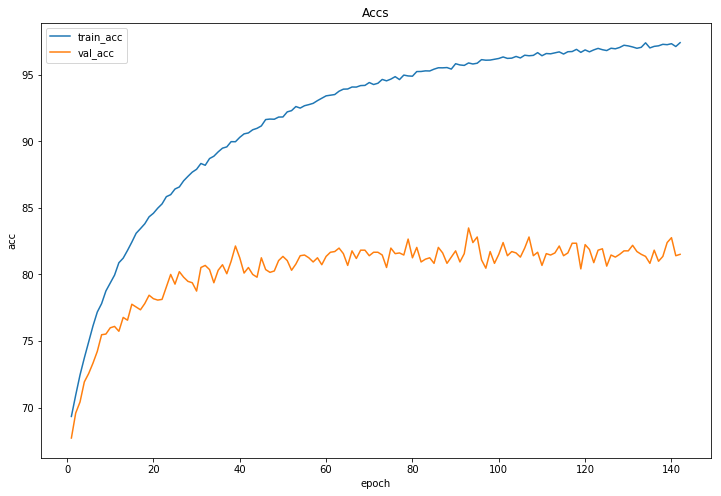

In [200]:
print_acc(acc_frame, 'Accs_VGG_16_BN.png')

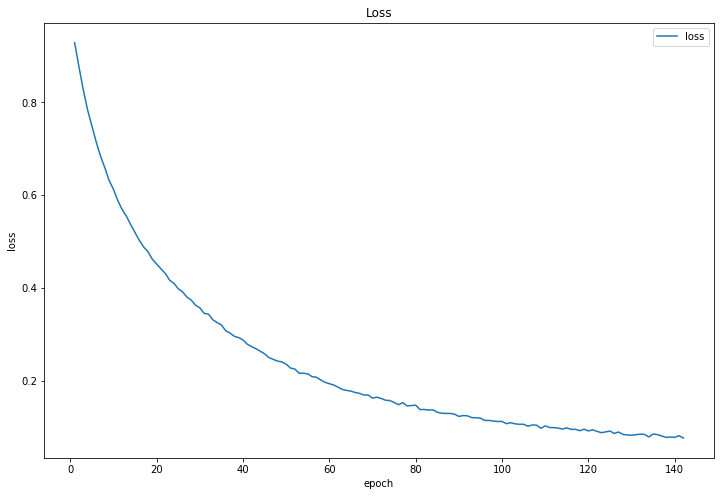

In [196]:
print_loss(acc_frame)

In [198]:
#save the network and its parameters as a dictionary
netInfo = {'network': net['output'], 'params': lasagne.layers.get_all_param_values(net['output'])}
Net_FileName = 'model_VGG_16_BN_' + str(142) + '.pkl'
# save the dictionary as a .pkl file
pickle.dump(netInfo, open(os.path.join('models/', Net_FileName), 'wb'),protocol=pickle.HIGHEST_PROTOCOL)

In [159]:
!scp ec2-user@ec2-35-157-222-80.eu-central-1.compute.amazonaws.com:~/code/models code/git/ATP_ML/HW/HW_6/models

The authenticity of host 'ec2-35-157-222-80.eu-central-1.compute.amazonaws.com (172.31.9.14)' can't be established.
ECDSA key fingerprint is 89:b5:6e:f4:b8:bb:55:2f:b3:3e:2b:d0:ed:2e:7e:27.
Are you sure you want to continue connecting (yes/no)? ^C


In [154]:
temp = pickle.load(open(os.path.join('models/', Net_FileName),'rb'))
all_params = temp['params']
buf = net['output']
lasagne.layers.set_all_param_values(buf, all_params) 

## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 